In [37]:
import panel as pn
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

pn.extension('plotly', 'mathjax', sizing_mode="stretch_width")

In [2]:
codes_column = 'Codes'
district_column = 'District'
total_area_land_use_column = 'Total Area Land Use 2011'
building_and_open_space_land_use_column = 'Building and Open Space Land Use 2011'
operating_area_land_use_column = 'Operating Area Land Use 2011'
recreational_area_land_use_column = 'Recreational Area Land Use 2011'
transportation_area_land_use_column = 'Transportation Area Land Use 2011'
agricultural_area_land_use_column = 'Agricultural Area Land Use 2011'
forest_area_land_use_column = 'Forest Area Land Use 2011'
water_area_land_use_column = 'Water Area Land Use 2011'
other_area_land_use_column = 'Other Area Land Use 2011'
total_settlement_and_transportation_areas_column = 'Total Settlement and Transportation Areas 2011'
operating_areas_without_mines_and_quarries_column = 'Operating Areas without Mines and Quarries 2011'
cemeteries_column = 'Cemeteries 2011'

translated_columns = [
    codes_column,
    district_column,
    total_area_land_use_column,
    building_and_open_space_land_use_column,
    operating_area_land_use_column,
    recreational_area_land_use_column,
    transportation_area_land_use_column,
    agricultural_area_land_use_column,
    forest_area_land_use_column,
    water_area_land_use_column,
    other_area_land_use_column,
    cemeteries_column
];
translated_columns

percentage_columns = list(map(lambda column: '% of ' + column + '', translated_columns[3:]))

In [45]:
def load_frankfurt_square_data():
    df = pd.read_csv("https://raw.githubusercontent.com/nitoloz/jupyter-notebooks/main/frankfurt-dashboard/stadtgebietflaechesemicolonsepdecimalpoint.csv", encoding='latin1', sep=';')
    filtered_df = df.filter(like='2011', axis=1)
    names_columns = df.iloc[:, :2]
    result_df = pd.concat([names_columns, filtered_df], axis=1)
    result_df = result_df.dropna(subset=["Flächennutzung Gesamtfläche  2011"])
    result_df = result_df.drop(columns=['Siedlungs- und Verkehrsflächen Insgesamt  2011', 'Siedlungs- und Verkehrsflächen Betriebsflächen ohne Gruben und Steinbrüche  2011'])

    for i, column in enumerate(result_df.columns):
        result_df = result_df.rename(columns={column: translated_columns[i]})
    return result_df
    
frankfurt_space = load_frankfurt_square_data()    
frankfurt_row = frankfurt_space[frankfurt_space['District'] == 'Frankfurt am Main'].reset_index(drop=True)
frankfurt_districts_df = frankfurt_space[frankfurt_space['District'] != 'Frankfurt am Main'].reset_index(drop=True)


In [47]:
def create_spaces_heatmap(frankfurt_spaces_df):
    percentage_df = pd.DataFrame()
    frankfurt_spaces_df = frankfurt_spaces_df.sort_values(district_column)
    for i, column in enumerate(frankfurt_districts_df.columns):
        if i > 2:
            percentage_df[percentage_columns[i-3]] = (100* frankfurt_districts_df[column] / frankfurt_districts_df["Total Area Land Use 2011"])

    percentage_df.index = frankfurt_districts_df['District']  # Replace with the desired row labels

    heatmap = px.imshow(percentage_df.transpose(),color_continuous_scale='Blues')
    #heatmap.update_layout(width=1000)  # Set the width to your desired value
    #heatmap.update_layout(height=400)  # Set the height to your desired value
    heatmap.update_traces(hovertemplate='District: %{x}<br>Land use: %{y}<br>Percentage of district area: %{z}%')
    heatmap.update_xaxes(tickangle=45)
    return heatmap

In [49]:
def load_frankfurt_population_data():
    df = pd.read_csv("https://raw.githubusercontent.com/nitoloz/jupyter-notebooks/main/frankfurt-dashboard/frankfurt-population.csv")
    df['Percentage of Men'] = 100*df['Men'] / df['Total Population']
    df['Percentage of Women'] = 100*df['Women'] / df['Total Population']
    df['Percentage of Foreigners'] = 100 * df['Total Foreigners'] / df['Total Population']
    df['Percentage of EU Foreigners'] = 100*df['EU Foreigners'] / df['Total Population']
    df['Percentage of Non-EU Foreigners'] = 100*df['Non-EU Foreigners'] / df['Total Population']
    df['Percentage of German'] = 100*df['German'] / df['Total Population']
    return df

In [53]:
population_df = load_frankfurt_population_data()
population_frankfurt_row = population_df[population_df['District'] == 'Frankfurt am Main'].reset_index(drop=True)
population_result_df = population_df[population_df['District'] != 'Frankfurt am Main'].reset_index(drop=True)

In [59]:
district_options = population_result_df['District'].unique().tolist()
district_select = pn.widgets.Select(name='District', options=district_options)

In [61]:
def update_district_sex_chart(district):
    district_population = population_result_df[population_result_df['District'] == district]
    fig = go.Figure(data=[go.Pie(labels=['Men', 'Women'], 
                             values=[district_population['Men'].values[0], district_population['Women'].values[0]])])
    fig.update_layout(title='Distribution by Sex')
    return fig

In [63]:
def update_district_foreigners_germans_chart(district):
    district_population = population_result_df[population_result_df['District'] == district]
    fig = go.Figure(data=[go.Pie(labels=['German', 'Total Foreigners'], 
                             values=[district_population['German'].values[0], district_population['Total Foreigners'].values[0]])])
    fig.update_layout(title='Foreigners vs. Germans')
    return fig

In [65]:
def update_district_foreigners_only_chart(district):
    district_population = population_result_df[population_result_df['District'] == district]
    fig = go.Figure(data=[go.Pie(labels=['EU Foreigners', 'Non-EU Foreigners'], 
                             values=[district_population['EU Foreigners'].values[0], district_population['Non-EU Foreigners'].values[0]])])
    fig.update_layout(title='EU vs Non-EU Foreigners')
    return fig

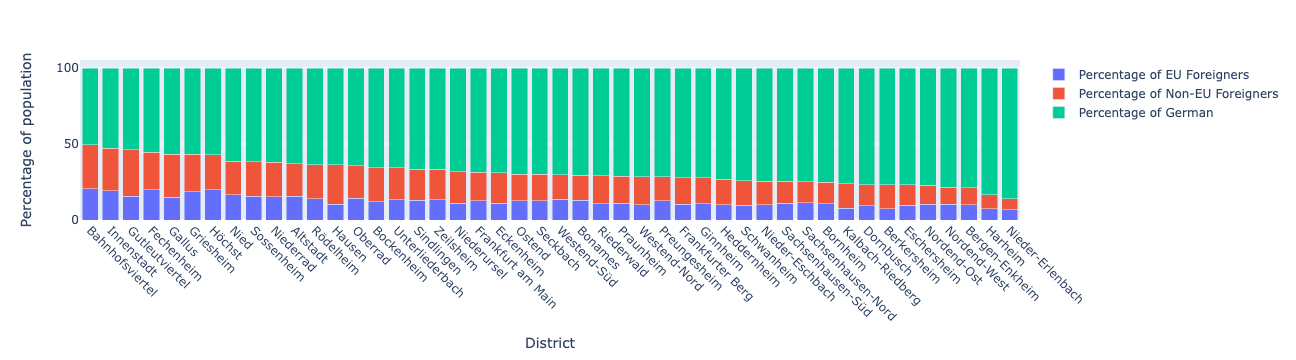

In [67]:
population_percentage_chart = px.bar(population_df.sort_values("Percentage of German"), x='District', y=['Percentage of EU Foreigners', 'Percentage of Non-EU Foreigners', 'Percentage of German'], barmode='stack')
population_percentage_chart.update_layout(
    yaxis_title="Percentage of population",
    legend_title=""
)
population_percentage_chart.update_xaxes(tickangle=45)

In [71]:
charts = pn.Row(pn.bind(update_district_sex_chart, district_select), pn.bind(update_district_foreigners_germans_chart, district_select),  pn.bind(update_district_foreigners_only_chart, district_select))
district_result = pn.Column(district_select, charts)

y_axis_options = translated_columns[2:]
y_axis_select = pn.widgets.Select(name='Y-Axis', options=y_axis_options)

def update_chart(y_axis):
    fig = px.bar(frankfurt_districts_df, x="District", y=y_axis)
    fig.update_layout(width=800)
    fig.update_xaxes(tickangle=45)
    return fig

districts_area = pn.Column(y_axis_select, pn.bind(update_chart, y_axis_select))

In [13]:
frankfurt_row
total_population = pn.indicators.Number(name='Total population', value=population_frankfurt_row.at[0, "Total Population"], format='{value}')
total_area = pn.indicators.Number(name='Total area', value=float(frankfurt_row.at[0, total_area_land_use_column]), format='{value} km²')

In [41]:
heatmap = create_spaces_heatmap(frankfurt_districts_df)

In [15]:
markdown = pn.pane.Markdown("""
# Frankfurt: A Growing Metropolis

Frankfurt, a vibrant city in Germany, has **experienced remarkable population growth** over the years. From a population of **646,550 in the year 2000**, the city's inhabitants have increased to **767,609 as of 2022**. The growth trajectory shows no signs of slowing down, with projections indicating that Frankfurt's population is **expected to reach 843,179 by the year 2045** [^1^].

The city's diverse neighborhoods contribute to its dynamic character. One of the largest parts of Frankfurt is **Sachsenhausen-Sud**, spanning an area of **5,915 square kilometers**. Within its urban landscape, the most densely populated area is **Gallus**, accommodating a substantial population of **44,047 residents**.

Frankfurt's continuous growth reflects its allure as an **economic and cultural hub**, making it an intriguing destination for people from around the world.

[^1^]: [Frankfurt Statistics Annual 2023](https://frankfurt.de/service-und-rathaus/zahlen-daten-fakten/publikationen/fsa/2023)
""")

In [16]:
numbers_row = pn.Column(pn.Row(total_population, pn.Spacer(), total_area), markdown)
result = pn.Column(numbers_row, districts_area, population_percentage_chart, heatmap, district_result)

In [73]:
header="<div style='float:right'><a target='_blank' href=https://anaconda.cloud/api/nbserve/launch_notebook?nb_url=https%3A%2F%2Fanaconda.cloud%2Fapi%2Fprojects%2Fa2331b9a-69a4-4bcb-8691-08968f670983%2Fversions%2Fd4ab3bfc-f1ce-45fa-b518-91e62ab80dfa%2Ffiles%2Ffrankfurt-dashboard.ipynb><img src='https://static.anaconda.cloud/content/a22d04e8445b700f28937ab3231b8cded505d0395c63b7a269696722196d5415'/></a>"

template = pn.template.FastGridTemplate(
    site="Frankfurt", 
    title="Population & Districts", 
    prevent_collision=True, 
    cols={'lg': 12, 'md': 6, 'sm': 6, 'xs': 4, 'xxs': 2}, 
    row_height=180,
    header_background="#fff",
    header_color="#000",
    header=header

)
template.main[0:3,0:6]=numbers_row
template.main[0:3,6:12]=districts_area
template.main[3:6,0:6]=population_percentage_chart
template.main[3:6,6:]=heatmap
template.main[6:9,0:12]=district_result
template.servable()

FastGridTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=2, language='en-GB', timezone='Europe/Berlin', timezone_offset=-60, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [139704241259728] Markdown(str, sizing_mode='stretch_width')
    [139704243064336] Column(sizing_mode='stretch_width')
        [0] Row(sizing_mode='stretch_width')
            [0] Number(name='Total population', value=767609)
            [1] Spacer(sizing_mode='stretch_width')
            [2] Number(format='{value} km²', name='Total area', value=24830.6)
        [1] Markdown(str, sizing_mode='stretch_width')
    [139704239549776] Column(sizing_mode='stretch_width')
        [0] Select(name='Y-Axis', options=['Total Area Land Use 2011...], sizing_mode='stretch_width', value='Total Area Land U...)
        [1] ParamFunction(function, _pane=Plotly, sizing_mode='stretch_width')
    [139704274638928] Plotly(Figure, sizing_mode='stretch_width')
    [139704239588368] Plotly(Figure, sizing_mode='stretch_width')
    [139704241344976] Column(sizing_mode='stretch_width')
        [0] Select(name='District', options=['Altstadt', 'Innenstadt',...], sizing_mode='stretch_width', value='Altstadt')
        [1] Row(sizing_mode='stretch_width')
            [0] ParamFunction(function, _pane=Plotly, sizing_mode='stretch_width')
            [1] ParamFunction(function, _pane=Plotly, sizing_mode='stretch_width')
            [2] ParamFunction(function, _pane=Plotly, sizing_mode='stretch_width')